# 梯度下降
梯度下降是理解梯度下降算法的关键

预处理 preconditioning 是梯度下降中的一种常用技术，还被沿用到更高级的算法中。



In [20]:
# f(x+ε)= f(x)+ εf'(x) + O(ε**2)
# 在一阶近似中，f(x+ε)可以通过在x处的函数值和一阶导数得出，
# 假设在负梯度方向上移动的ε会减少f

import sys
%matplotlib inline
sys.path.append("../")
import numpy as np
import torch as t 
from pltutils import *

def f(x):
    return  x**2
def f_grad(x):
    return 2*x

# perform ： f(x - eta f'(x)) = f(x) - eta f'^2(x) + O(eta^2f'^2(x))
# if we use x = x - eta*f'(x), then the value of f(x) might be smaller
def gd(eta,f_grad,ep=10):
    x= 10.
    results = [x]
    for i in range(ep):
        x-=eta*f_grad(x)
        results.append(x)
    print(f"epoch {ep}, x:{x:f}")
    return results

results = gd(0.2,f_grad,50)


epoch 50, x:0.000000


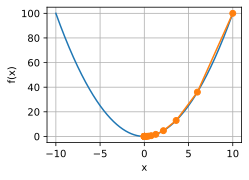

In [21]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    set_figsize()
    plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])


show_trace(results, f)


epoch 10, x:3.486784


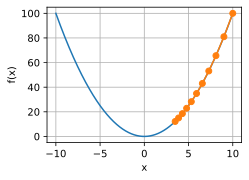

In [22]:
show_trace(gd(0.05, f_grad), f)


epoch 10, x:61.917364


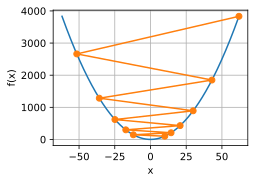

In [23]:
show_trace(gd(1.1, f_grad), f)


# 较差的学习率会导致停留在局部最小值


epoch 10, x:-1.528166


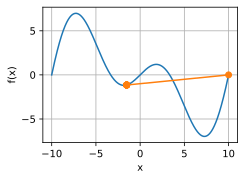

In [24]:
c = t.tensor(0.15 * np.pi)


def f(x):  # 目标函数
    return x * t.cos(c * x)


def f_grad(x):  # 目标函数的梯度
    return t.cos(c * x) - c * x * t.sin(c * x)


show_trace(gd(2, f_grad,10), f)


# 多元梯度下降
考虑x=[x1,x2,x....,xd].T的情况，梯度也是多元的,对于多变量函数，可以使用相应的泰勒近似来思考。

In [25]:
def train_2d(trainer, steps=20, f_grad=None):  # @save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results


def show_trace_2d(f, results):  # @save
    """显示优化过程中2D变量的轨迹"""
    set_figsize()
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1),indexing="xy")
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')


epoch 20, x1: -0.057646, x2: -0.000073


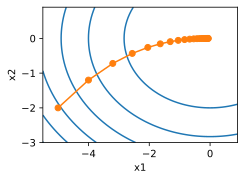

In [16]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2


def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)


def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)


eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))


在梯度较小的时候，下降很慢，如果过大的话又不行，所以选择一个合适的学习率eta是很棘手的，如果我们能够自动确定eta或者不必选择学习率就好了。

我们将目标函数的值和梯度、曲率的二阶方法都考虑进去就可以解决这个问题，于是可以用**牛顿法**来解决

关于[Hessian矩阵](https://zhuanlan.zhihu.com/p/138334587)它可以用来判断梯度下降的速率、判断极值和鞍点。

epoch 10, x: tensor(0.)


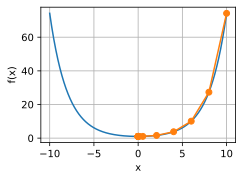

In [28]:
# 在牛顿法中，使用Hessian矩阵来进行梯度更新
c = torch.tensor(0.5)


def f(x):  # O目标函数
    return torch.cosh(c * x)


def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)


def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)


def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(20):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results


show_trace(newton(), f)


epoch 10, x: tensor(26.8341)


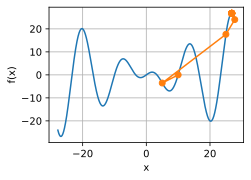

In [29]:
c = torch.tensor(0.15 * np.pi)


def f(x):  # 目标函数
    return x * torch.cos(c * x)


def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)


def f_hess(x):  # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)


show_trace(newton(), f)


epoch 10, x: tensor(7.2694)


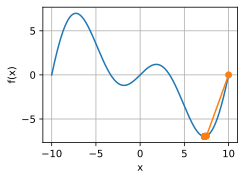

In [30]:
show_trace(newton(0.5), f)
